<br>  

# **OPTIONAL: OpenAI Ada Embeddings
***
## **WARNING: HIGHLY RECOMMEND THAT YOU RUN THIS EXERCISE LOCALLY.  
## THE EMBEDDINGS GENERATED TAKE UP 250MB OF DISK SPACE AND WILL TAKE OVER 30 MINUTES TO DOWNLOAD FROM GOOGLE COLAB

This optional section explores the process for creating text embeddings using the powerful OpenAI model `text-embedding-ada-002`.  For additional details about this process see the OpenAI [Embeddings documentation](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings). 

### Overview

Even if you don't plan on using the `text-embedding-ada-002` model for your particular use case, this exercise will, at the very least, provide you with a basis for comparison against one of the most popular (currently) embeddings frameworks on the commercial market.  While there are several ways to approach embeddings creation through the OpenAI API, we will use the code provided by LlamaIndex, as it is one the cleanest implementations that I've seen.  The output from this exercise will be a pandas DataFrame of text/vector pairs similar to what we derived from Assignment 1.2. 

In [1]:
#!pip install llama-index

In [1]:
import os
import json
import openai
import tiktoken
from tiktoken import Encoding
from typing import Union, List, Tuple
from getpass import getpass
from tqdm import tqdm
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(), override=True)

In [2]:
#set api key
openai.api_key = os.environ['OPENAI_API_KEY']

# alternatively use copy/paste
# openai.api_key = getpass(prompt='Enter your OpenAI API key')

### Instantiate tokenizer/encoder

In [3]:
#define the model we want to use for the tokenizer
model_type = "text-embedding-3-small"
encoding = tiktoken.encoding_for_model(model_type)

### Load raw data

In [4]:
data_path='../../data/huberman_labs.json'
with open(data_path) as f:
    data = json.load(f)

### Extract contents

In [5]:
#only need the contents from our data
contents = [d['content'] for d in data]

### Split contents

In [6]:
from llama_index.legacy.text_splitter import SentenceSplitter #one of the best on the market

# #set chunk size and instantiate your SentenceSplitter
chunk_size = 256
gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=0)
splits = [gpt35_txt_splitter.split_text(episode) for episode in tqdm(contents)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:14<00:00, 13.13it/s]


### Estimate cost of job

As a best practice, it's always a good idea to estimate the cost of using OpenAI **prior** to kicking off a job.  The `get_cost` function does just that.  It takes an encoder, which we defined previously, and a corpus, and allows the user to set the price per 1M tokens.  The price will change depending on what action you're looking to take, but the default is $0.02 / 1M tokens which is the current (Apr 2024) cost for using the `text-embedding-3-small` endpoint. 

In [7]:
#should match previously calculated token count for corpus
def get_cost(encoder: Encoding, 
             corpus: Union[str, List[str]], 
             price: float=0.02, 
             return_tokens: bool=False
             ) -> Union[float, Tuple[float, List[int]]]:
    '''
    Given a text encoder and a corpus of text, this function will calculate the total 
    cost, as determined by the price param, of using the OpenAI API. The price is 
    per 1,000 tokens. 
    '''
    if isinstance(corpus, str):
        encoded = encoder.encode(corpus)
        token_count = len(encoded)
    elif isinstance(corpus, list):
        encoded = encoder.encode_batch(corpus)
        token_count = sum(list(map(len, encoded)))
    print(f'Total Tokens: {token_count}')
    cost = token_count//1_000_000 * price
    print(f'Total Cost: ${cost:.2f}')
    if return_tokens:
        return cost, encoded
    return cost

In [8]:
get_cost(encoding, contents)

Total Tokens: 5443407
Total Cost: $0.10


0.1

The Total Tokens should match the same number we derived when capturing analytics on our corpus earlier in the notebook.  At a price of \\$0.02 per 1M tokens, we can see that this text embeddings action should cost about \\$0.10 (10 cents). In preparation for this course I ran this exercise and can confirm that I was billed exactly 10 cents to embed the entire Huberman Lab corpus. Below is a screenshot of my OpenAI usage page after completing this embeddings exercise. 

![embeddings usage]( 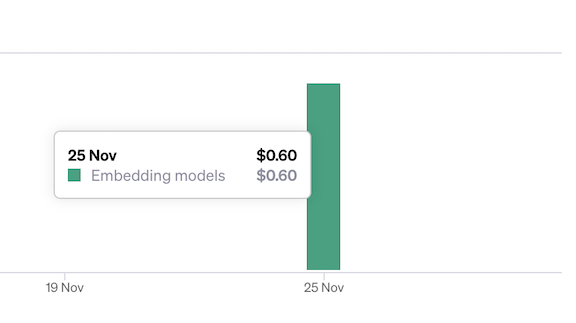)

<div>
    <img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
</div>

### Get Embeddings (using LlamaIndex)

To handle this job without using LlamaIndex is no small feat, you would have to account for the various rate limits that OpenAI has in place, which change depending on your pricing tier and the actions that you want to perform.  There are requests per minute (RPM), requests per day (RPD) and tokens per minute (TPM) rate limits to consider.  If you are at pricing Tier 1, for example, you'd have a TPM limit of 1,000,000 tokens per minute, so this job will take at least six minutes to complete.  See the [OpenAI Rate Limits page](https://platform.openai.com/docs/guides/rate-limits?context=tier-one) for additional detail. Thankfully, LlamaIndex handles all of these considerations under the hood.  I was able to complete this task in 2.5 minutes (your time may vary depending on your pricing tier). 

In [9]:
from llama_index.embeddings.openai import OpenAIEmbedding

In [10]:
# model_type = "text-embedding-3-small"
embed_model = OpenAIEmbedding(embed_batch_size=150, api_key=openai.api_key)

ImportError: cannot import name 'global_handler' from 'llama_index.core' (unknown location)

### Flatten Content 
This part is very important because the `get_text_embedding_batch` method only accepts a list of strings as an arg.  This batch feature is very convenient though because it allows the user to dump their entire corpus into the function at one go and allow the code to perform all the heavy lifting. 

In [30]:
#converts list of lists of text (strings) into a single list of text (strings)
flattened_content = [chunk for alist in splits for chunk in alist]

In [31]:
%%time
#get ada embeddings   ---> The show_progress bar does not work!
ada_embs = embed_model.get_text_embedding_batch(flattened_content, show_progress=True)

Generating embeddings:   0%|          | 0/23905 [00:00<?, ?it/s]

CPU times: user 6.09 s, sys: 848 ms, total: 6.94 s
Wall time: 1min 53s


In [34]:
len(ada_embs[0]), len(ada_embs)

(1536, 23905)

In [35]:
#convert output to DataFrame to visualize and then save results as parquet
llama_df = pd.DataFrame({'text': flattened_content, 'embeddings': ada_embs})

In [36]:
llama_df

,text,embeddings
0,"Welcome to the Huberman Lab guest series, wher...","[0.029238032177090645, 0.018185269087553024, 0..."
1,"Everything from how to time lighting, temperat...","[0.038538552820682526, 0.013730175793170929, 0..."
2,Walker and I are very excited to share the mat...,"[0.03437370806932449, 0.007441236171871424, 0...."
3,Eight Sleep makes it very easy to control the ...,"[0.031218120828270912, 0.008673896081745625, 0..."
4,"Initially, I had to do therapy against my will...","[-0.002630895236507058, 0.0017472612671554089,..."
...,...,...
23900,We're also going to talk about the data that s...,"[0.006510106381028891, -0.004767164122313261, ..."
23901,"Welcome to the Huberman Lab Podcast, where we ...","[0.012734472751617432, 0.011004531756043434, 0..."
23902,"So for instance, we might take an entire month...","[-0.010496060363948345, -0.01148151233792305, ..."
23903,So the comment section is a place for you to g...,"[-0.013747996650636196, 0.027308398857712746, ..."


In [ ]:
#save as parquet for later use
# llama_df.to_parquet('./impact_theory_ada_embs.parquet', index=False)

The remaining part of joining the text/vector pairs with the episode metadata is left as an exercise to the user.  Something to keep in mind is that the pairs are no longer chunked as episodes, so keep that in mind when joining back with episode metadata.  Also, **very important** if you want to compare the effectiveness of these embeddings against other embedding methods (`all-MiniLM-L6-v2`) make sure that you use the same `doc_ids` that you created when completing Assignment 1.3.  The `doc_ids` will be used as our term of measurement when doing Retrieval Evaluation in Notebook 3 of the course. 